In [121]:
import csv
import numpy as np
from matplotlib import pyplot as plt

data = np.genfromtxt('IR_signal.csv', delimiter=',', dtype=float)
data = np.around(data,2)

np.set_printoptions(precision=3, suppress=True)


    

In [ ]:
def suppress_outliers(data):
    mean = np.mean(data)
    sd = np.std(data)
    med = np.median(data)
    distance_from_mean = abs(data - mean)
    max_deviations = 3
    
    low = np.median(data[data < med])
    high = np.median(data[data > med])

    # Deal with the artifact sometimes caused by the first reading coming in way above or way below average as the sensor calibrates its baseline
    if distance_from_mean[0] > max_deviations * sd:
        data[0] = data[1]
        distance_from_mean[0] = distance_from_mean[1]


    # Impute upper quartile for the high outliers and lower quartile for the low outliers

    data[(distance_from_mean > max_deviations * sd) & (data > mean)] = med
    data[(distance_from_mean > max_deviations * sd) & (data < mean)] = low
 
    return data

outliers_removed = list()

for i in range(5):
    outliers_removed.append(suppress_outliers(data[i]))

data = outliers_removed


# plt.plot(X, data.T)
# plt.show()



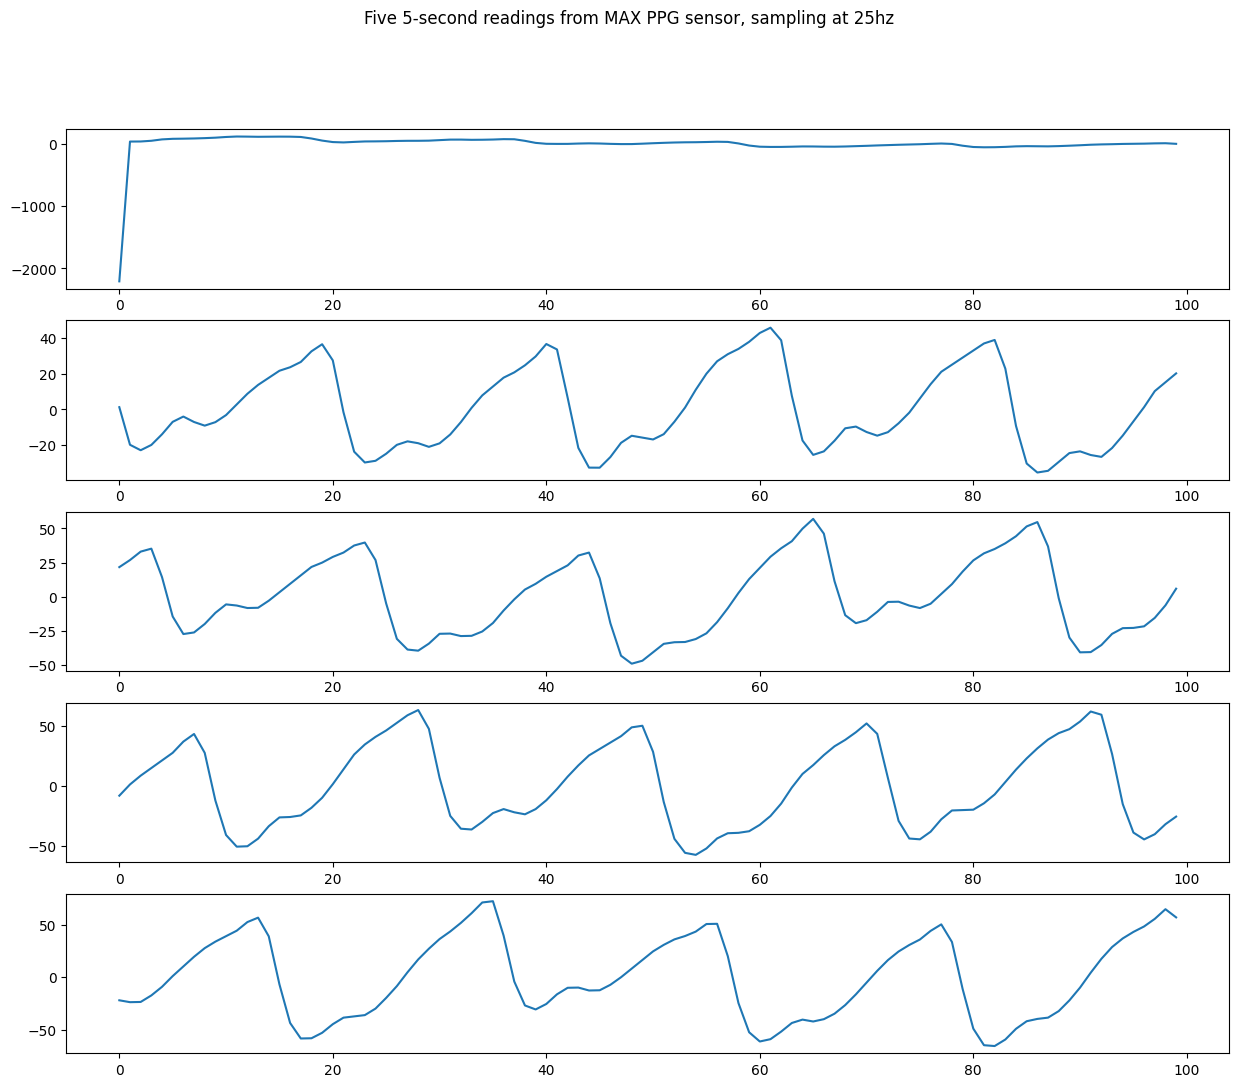

In [122]:
#define grid
plt.figure(figsize=(15,12))
plt.suptitle("Five 5-second readings from MAX PPG sensor, sampling at 25hz")

for i, trial in enumerate(data):
    ax = plt.subplot(5,1,i+1)
    X = np.arange(len(trial))
    ax.plot(X,trial)

    

After comparing 50 and 25 hz, 25hz sampling is the clear winner.

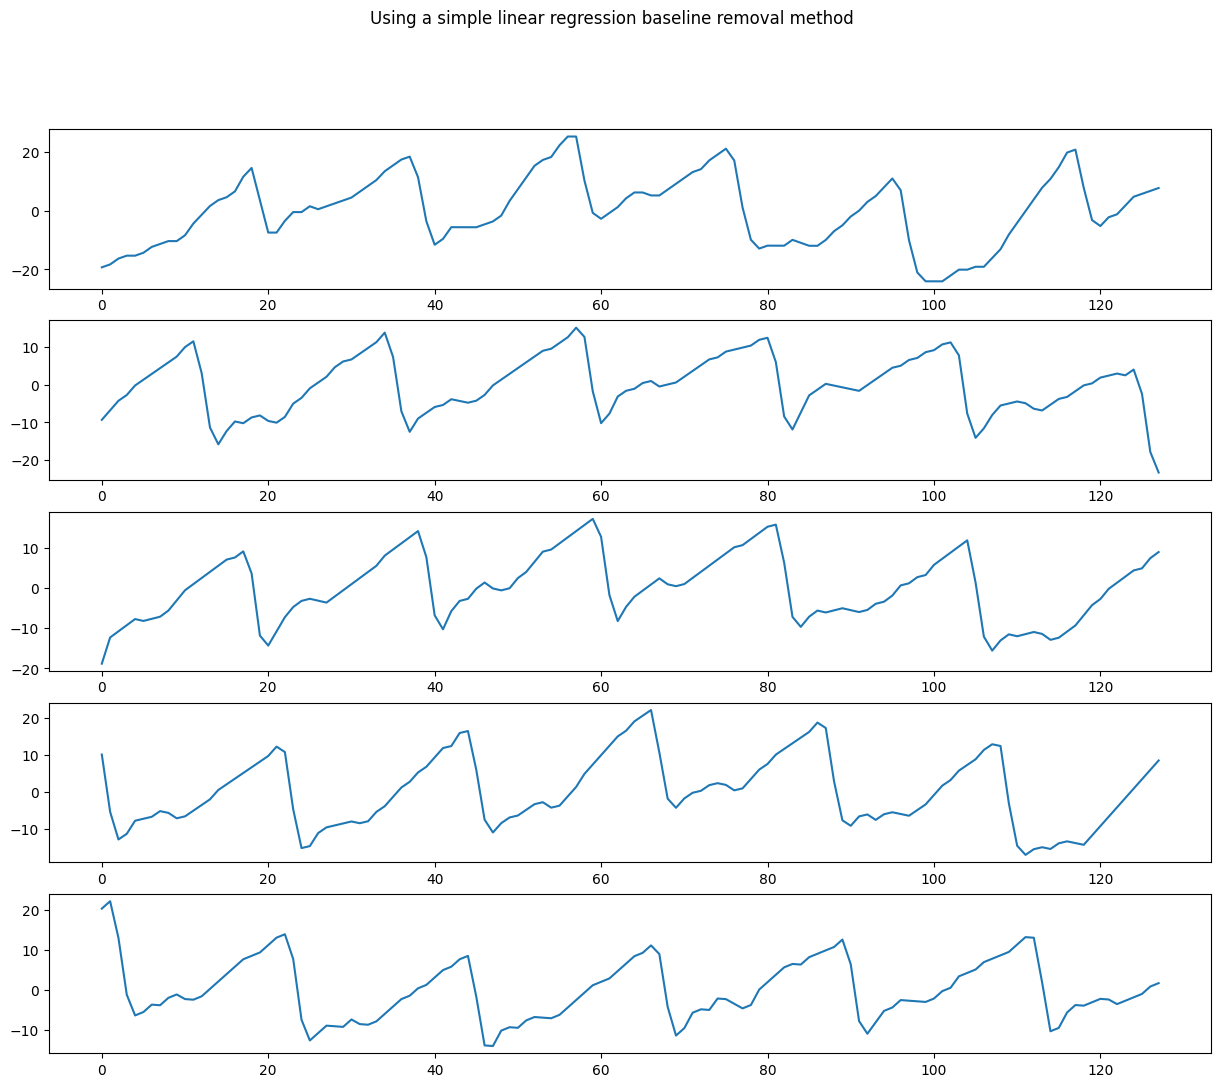

In [112]:
# Try a simple regression baseline removal method
plt.figure(figsize=(15,12))
plt.suptitle("Using a simple linear regression baseline removal method")

for i, trial in enumerate(data):
    ax = plt.subplot(5,1,i+1)
    x = np.arange(len(trial))
    polynomial = np.polyfit(x, trial,deg=1)
    baseline = x * polynomial[0] + polynomial[1]
    baseline_removed = trial - baseline
    data[i] = baseline_removed
    ax.plot(x, baseline_removed)


A simple peak detection algorithm could work fine for this.

In [115]:
def detect_peaks(signal):
    """Naive linear search to find the peaks of the algorithm
    
    Returns a tuple of peak indices
    """
    peak_indices = []
    baseline = np.median(signal[signal > np.median(signal)])
    peak_value = -999
    peak_index = -999

    for i, value in enumerate(signal):
        if value > baseline:
            if value > peak_value or peak_value == -999:
                peak_index = i
                peak_value = value
        elif value < baseline and peak_value != -999:
            peak_indices.append(peak_index)
            peak_index = -999
            peak_value = -999
    
    if peak_index != -999:
        peak_indices.append(peak_index)

    
    return tuple(peak_indices)


def rate_from_peaks(peak_indices, sample_rate):
    peak_differences = []
    for i in range(len(peak_indices)-1):
        peak_differences.append(abs(peak_indices[i+1] - peak_indices[i]))
    
    rate = np.min(np.array(peak_differences)) / 25 * 60
    return rate



In [118]:
for i in range(5):
    print(rate_from_peaks(detect_peaks(data[i]),25))

45.6
52.8


KeyboardInterrupt: 

<StemContainer object of 3 artists>

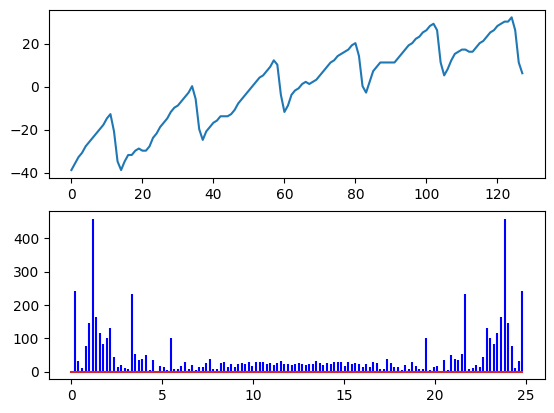

In [63]:


sample_data = data[1]
fft = np.real(np.fft.fft(sample_data))
time = np.arange(len(sample_data))

#frequency axis
sr = 25
N = len(fft)
T = N / sr
freq = time / T

nyquist = int(N/2)

freq_first_half = freq[:nyquist]
fft_first_half = fft[:nyquist] / nyquist

fig, axs = plt.subplots(2)

axs[0].plot(time,sample_data)
axs[1].stem(freq,np.abs(fft), 'b', \
    markerfmt=" ")


In [9]:
fundamental = freq[np.argmax(np.abs(fft)[0:10])]

print(fundamental*60)

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (4027137592.py, line 1)